In [1]:
from dotenv import load_dotenv
import os
from google.cloud import bigquery
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")

In [2]:
load_dotenv()
key = os.getenv("linkfile")
client = bigquery.Client.from_service_account_json(key)

In [3]:
query_clean = """
SELECT DISTINCT
  carrier,
  departure_date,
  origin,
  destination,
  economy_emissions_grams_per_pax  AS economy
FROM
  `bigquery-public-data.travel_impact_model.flights_impact_data`
WHERE
  economy_emissions_grams_per_pax > 0
LIMIT 30000;
"""

df = client.query(query_clean).to_dataframe()
df.head()

,carrier,departure_date,origin,destination,economy
0,0N,2024-04-01,YFH,YQT,102048
1,2A,2024-08-23,CGP,DAC,33222
2,2A,2024-12-09,CGP,DAC,33222
3,2A,2024-05-17,DAC,SPD,35216
4,2A,2024-04-12,DAC,CXB,38003


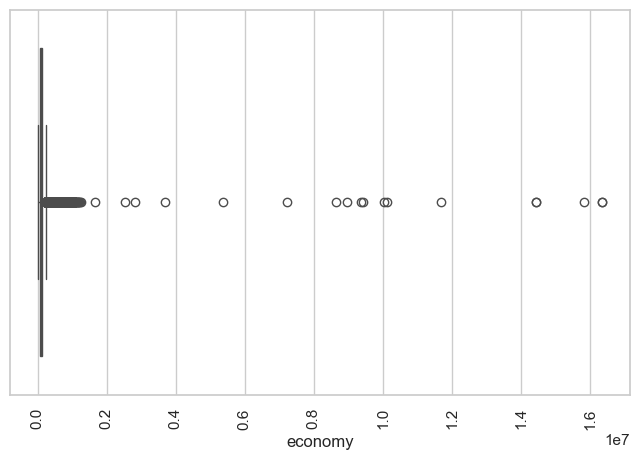

In [4]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["economy"])
plt.xticks(rotation=90)
plt.show()

In [5]:
def remove_outliers_iqr(df, column):
    df[column] = df[column].astype(float)

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered


In [6]:
df1 = remove_outliers_iqr(df, "economy")

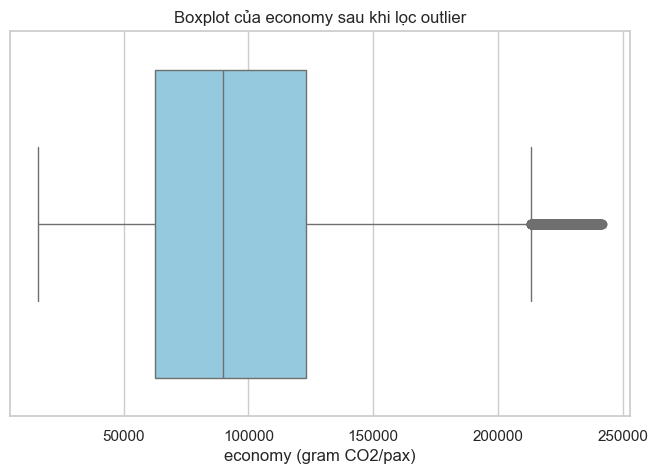

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1["economy"], color="skyblue")
plt.title("Boxplot của economy sau khi lọc outlier")
plt.xlabel("economy (gram CO2/pax)")
plt.show()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27792 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carrier         27792 non-null  object 
 1   departure_date  27792 non-null  dbdate 
 2   origin          27792 non-null  object 
 3   destination     27792 non-null  object 
 4   economy         27792 non-null  float64
dtypes: dbdate(1), float64(1), object(3)
memory usage: 1.3+ MB


In [9]:
df1["economy"].describe()

count     27792.000000
mean      97242.400403
std       46020.118342
min       15718.000000
25%       62666.500000
50%       89639.000000
75%      122900.000000
max      241639.000000
Name: economy, dtype: float64

In [10]:
df1.duplicated().sum()

np.int64(0)

In [11]:
df1['departure_date'] = pd.to_datetime(df1['departure_date'], errors='coerce')

In [12]:
df1['year'] = df1['departure_date'].dt.year
df1['month'] = df1['departure_date'].dt.month
df1['day'] = df1['departure_date'].dt.day

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day
0,0N,2024-04-01,YFH,YQT,102048.0,2024,4,1
1,2A,2024-08-23,CGP,DAC,33222.0,2024,8,23
2,2A,2024-12-09,CGP,DAC,33222.0,2024,12,9
3,2A,2024-05-17,DAC,SPD,35216.0,2024,5,17
4,2A,2024-04-12,DAC,CXB,38003.0,2024,4,12


In [13]:
df1['day_of_week'] = df1['departure_date'].dt.dayofweek
df1['quarter'] = df1['departure_date'].dt.quarter

df1.head()


,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter
0,0N,2024-04-01,YFH,YQT,102048.0,2024,4,1,0,2
1,2A,2024-08-23,CGP,DAC,33222.0,2024,8,23,4,3
2,2A,2024-12-09,CGP,DAC,33222.0,2024,12,9,0,4
3,2A,2024-05-17,DAC,SPD,35216.0,2024,5,17,4,2
4,2A,2024-04-12,DAC,CXB,38003.0,2024,4,12,4,2


In [14]:
df1['sin_month'] = np.sin(2 * np.pi * df1['month'] / 12)
df1['cos_month'] = np.cos(2 * np.pi * df1['month'] / 12)

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month
0,0N,2024-04-01,YFH,YQT,102048.0,2024,4,1,0,2,8.660254e-01,-0.500000
1,2A,2024-08-23,CGP,DAC,33222.0,2024,8,23,4,3,-8.660254e-01,-0.500000
2,2A,2024-12-09,CGP,DAC,33222.0,2024,12,9,0,4,-2.449294e-16,1.000000
3,2A,2024-05-17,DAC,SPD,35216.0,2024,5,17,4,2,5.000000e-01,-0.866025
4,2A,2024-04-12,DAC,CXB,38003.0,2024,4,12,4,2,8.660254e-01,-0.500000


In [15]:
df1['sin_dayofweek'] = np.sin(2 * np.pi * df1['day_of_week'] / 7)
df1['cos_dayofweek'] = np.cos(2 * np.pi * df1['day_of_week'] / 7)

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek
0,0N,2024-04-01,YFH,YQT,102048.0,2024,4,1,0,2,8.660254e-01,-0.500000,0.000000,1.000000
1,2A,2024-08-23,CGP,DAC,33222.0,2024,8,23,4,3,-8.660254e-01,-0.500000,-0.433884,-0.900969
2,2A,2024-12-09,CGP,DAC,33222.0,2024,12,9,0,4,-2.449294e-16,1.000000,0.000000,1.000000
3,2A,2024-05-17,DAC,SPD,35216.0,2024,5,17,4,2,5.000000e-01,-0.866025,-0.433884,-0.900969
4,2A,2024-04-12,DAC,CXB,38003.0,2024,4,12,4,2,8.660254e-01,-0.500000,-0.433884,-0.900969


In [16]:
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

In [17]:
df1['season'] = df1['month'].apply(get_season)
df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek,season
0,0N,2024-04-01,YFH,YQT,102048.0,2024,4,1,0,2,8.660254e-01,-0.500000,0.000000,1.000000,spring
1,2A,2024-08-23,CGP,DAC,33222.0,2024,8,23,4,3,-8.660254e-01,-0.500000,-0.433884,-0.900969,summer
2,2A,2024-12-09,CGP,DAC,33222.0,2024,12,9,0,4,-2.449294e-16,1.000000,0.000000,1.000000,winter
3,2A,2024-05-17,DAC,SPD,35216.0,2024,5,17,4,2,5.000000e-01,-0.866025,-0.433884,-0.900969,spring
4,2A,2024-04-12,DAC,CXB,38003.0,2024,4,12,4,2,8.660254e-01,-0.500000,-0.433884,-0.900969,spring


In [18]:
X = df1.drop("departure_date", axis=1)

In [19]:
X = X.rename(columns={"economy": "gramco2"})

In [20]:
X.head()

,carrier,origin,destination,gramco2,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek,season
0,0N,YFH,YQT,102048.0,2024,4,1,0,2,8.660254e-01,-0.500000,0.000000,1.000000,spring
1,2A,CGP,DAC,33222.0,2024,8,23,4,3,-8.660254e-01,-0.500000,-0.433884,-0.900969,summer
2,2A,CGP,DAC,33222.0,2024,12,9,0,4,-2.449294e-16,1.000000,0.000000,1.000000,winter
3,2A,DAC,SPD,35216.0,2024,5,17,4,2,5.000000e-01,-0.866025,-0.433884,-0.900969,spring
4,2A,DAC,CXB,38003.0,2024,4,12,4,2,8.660254e-01,-0.500000,-0.433884,-0.900969,spring


In [21]:
size_in_bytes = X.memory_usage(deep=True).sum()
size_in_gb = size_in_bytes / (1024**3)
print(f"Kích thước DataFrame: {size_in_gb:.2f} GB")

Kích thước DataFrame: 0.01 GB


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27792 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carrier        27792 non-null  object 
 1   origin         27792 non-null  object 
 2   destination    27792 non-null  object 
 3   gramco2        27792 non-null  float64
 4   year           27792 non-null  int32  
 5   month          27792 non-null  int32  
 6   day            27792 non-null  int32  
 7   day_of_week    27792 non-null  int32  
 8   quarter        27792 non-null  int32  
 9   sin_month      27792 non-null  float64
 10  cos_month      27792 non-null  float64
 11  sin_dayofweek  27792 non-null  float64
 12  cos_dayofweek  27792 non-null  float64
 13  season         27792 non-null  object 
dtypes: float64(5), int32(5), object(4)
memory usage: 2.7+ MB


In [23]:
X_ = X[['sin_month', 'cos_month','sin_dayofweek', 'cos_dayofweek','gramco2']]

In [24]:
from sklearn.preprocessing import OneHotEncoder


categorical_cols = ['season','carrier', 'origin', 'destination', 'year','quarter','month', 'day']


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[categorical_cols])
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
X_cat_df = pd.DataFrame(X_cat, columns=cat_feature_names, index=X.index)


X_encoded = pd.concat([X_cat_df,X_], axis=1)
X_encoded.shape

(27792, 4854)

In [25]:
X_encoded = X_encoded.dropna()

In [26]:
X_encoded.shape

(27792, 4854)

In [27]:
size_in_bytes = X_encoded.memory_usage(deep=True).sum()
size_in_gb = size_in_bytes / (1024**3)
print(f"Kích thước DataFrame: {size_in_gb:.2f} GB")

Kích thước DataFrame: 1.01 GB


In [28]:
X_encoded.to_csv("train.csv", index=False)

In [29]:
from joblib import dump
dump(ohe, "model/onehot_encoder.pkl")

['model/onehot_encoder.pkl']